In [29]:
#pip install scikit-learn


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [31]:
behav = pd.read_csv('../data/300behavior.csv')

# Assuming behav is your DataFrame and it's already imported
# Replace all occurrences of 3 with 2 in the 'NextLever' column
behav['NextLever'] = behav['NextLever'].replace(3, 2)
B23behav = behav[(behav['Trial#'] > 20) & ~(behav['Trial#'].isin([40, 60]))]

B23behav.head

<bound method NDFrame.head of       ID    Date  Trial#  Lever  NextLever  WSLS  LeverZmax  LeverZmin  \
20    16  230123      21      3          2     1   2.401602  -1.003824   
21    16  230123      22      3          2     1   2.926855  -1.217437   
22    16  230123      23      3          2     1   1.696856  -1.406294   
23    16  230123      24      3          2     1   1.724995  -1.203465   
24    16  230123      25      3          2     1   0.747431  -1.450247   
...   ..     ...     ...    ...        ...   ...        ...        ...   
1672  32  230407      51      3          1     3   3.332265  -1.602789   
1673  32  230407      52      1          0     0   4.506867  -2.054242   
1674  32  230407      55      1          2     0   0.637471  -3.201188   
1675  32  230407      56      2          0     2   2.911747  -0.353442   
1676  32  230407      59      1          0     0   1.568098  -1.403199   

        LeverAUC    HLZmax    HLZmin       HLAUC  
20     80.581480  2.714354 -3.

In [32]:
#pip install imblearn


In [33]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Example dataset
# Replace this with your actual dataset
df = B23behav

# Assuming df is your DataFrame and 'NextLever' is the target variable
X = B23behav[['LeverZmax','HLZmax']]  # Predictor variables
y = B23behav['NextLever']  # Target variable with three categories

# Splitting the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying SMOTE (Synthetic Minority Over-sampling Technique)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


In [34]:
from sklearn.linear_model import LogisticRegression

# Creating the logistic regression model with class weights
model = LogisticRegression(max_iter=1000,multi_class='multinomial', solver='lbfgs', class_weight='balanced')


# Fit the model on the resampled data
model.fit(X_train_res, y_train_res)

# Predict on the testing data
y_pred = model.predict(X_test)

# Evaluating the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.53      0.17        19
           1       0.14      0.67      0.24        30
           2       0.87      0.24      0.37       263

    accuracy                           0.29       312
   macro avg       0.37      0.48      0.26       312
weighted avg       0.76      0.29      0.35       312

Confusion Matrix:
 [[ 10   6   3]
 [  4  20   6]
 [ 87 114  62]]


In [35]:
import statsmodels.api as sm

# Fit logistic regression using statsmodels for detailed statistics
# Add a constant to the input features
X_stat = sm.add_constant(X_train)
model_stat = sm.MNLogit(y_train, X_stat)
result_stat = model_stat.fit()

# Print summary for detailed statistics
print(result_stat.summary())


Optimization terminated successfully.
         Current function value: 0.542113
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:              NextLever   No. Observations:                  728
Model:                        MNLogit   Df Residuals:                      722
Method:                           MLE   Df Model:                            4
Date:                Tue, 02 Jan 2024   Pseudo R-squ.:                 0.03949
Time:                        15:34:40   Log-Likelihood:                -394.66
converged:                       True   LL-Null:                       -410.89
Covariance Type:            nonrobust   LLR p-value:                 1.545e-06
NextLever=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5159      0.407      3.729      0.000       0.719       2.313
LeverZmax      -0.4415    

In [36]:
from sklearn.inspection import permutation_importance
feature_names = ['LeverZmax','HLZmax']
# Perform permutation importance
perm_importance = permutation_importance(model, X_test, y_test)

# Summarize in a DataFrame
perm_importance_df = pd.DataFrame({'feature': feature_names, 'importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='importance', ascending=False)

print(perm_importance_df)


     feature  importance
0  LeverZmax    0.014744
1     HLZmax   -0.014744


c:\Users\wonnp\Documents\GitHub\ML-For-Beginners\.virtualenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


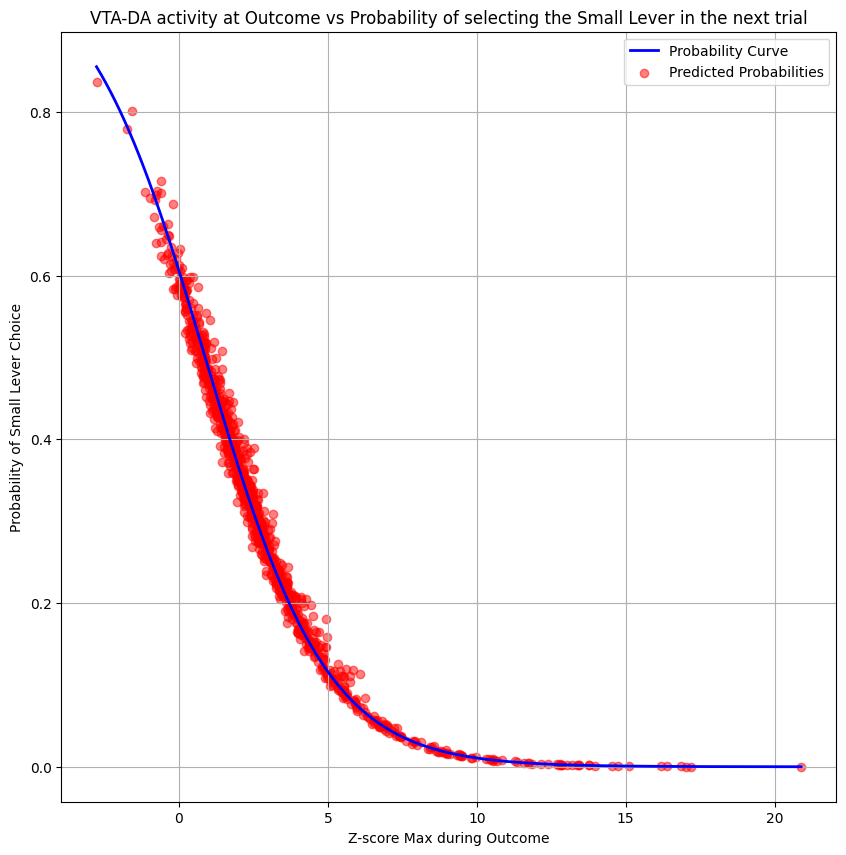

In [37]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = B23behav[feature_names]

# Calculate the mean of other features in your dataset
X_mean = df.drop('LeverZmax', axis=1).mean()

# Generate a range of values for LeverZmax
lever_zmax_range = np.linspace(df['LeverZmax'].min(), df['LeverZmax'].max(), 300)
X_pred = np.repeat(X_mean.values.reshape(1, -1), len(lever_zmax_range), axis=0)
X_pred = np.insert(X_pred, 0, lever_zmax_range, axis=1)  # Insert LeverZmax values

# Calculate the predicted probability of NextLever=1 for the curve
prob_next_lever_1_curve = model.predict_proba(X_pred)[:, 1]

# Calculate the predicted probability of NextLever=1 for each data point
X_data_points = df.copy()
X_data_points['LeverZmax'] = X_data_points['LeverZmax'].astype(float)
prob_next_lever_1_points = model.predict_proba(X_data_points)[:, 1]

# Plotting the probability curve
plt.figure(figsize=(10, 10))
plt.plot(lever_zmax_range, prob_next_lever_1_curve, color='blue', label='Probability Curve', linewidth=2)

# Plotting the individual data points with their predicted probabilities
plt.scatter(df['LeverZmax'], prob_next_lever_1_points, color='red', label='Predicted Probabilities', alpha=0.5)

plt.title('VTA-DA activity at Outcome vs Probability of selecting the Small Lever in the next trial')
plt.xlabel('Z-score Max during Outcome')
plt.ylabel('Probability of Small Lever Choice')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\wonnp\Documents\GitHub\ML-For-Beginners\.virtualenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


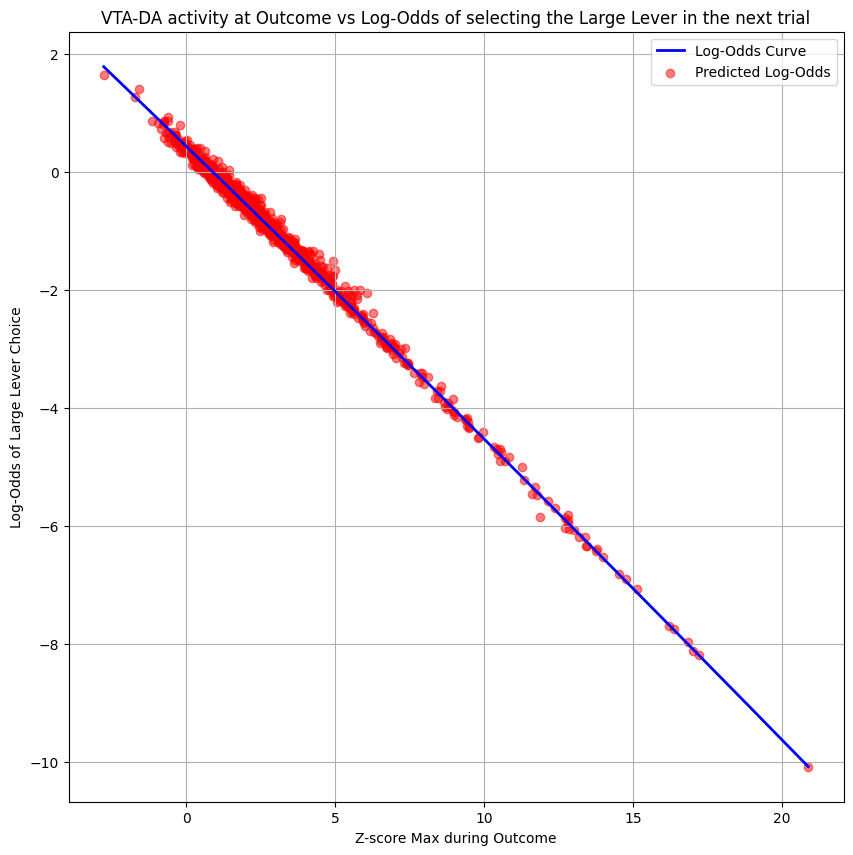

In [42]:

# Assuming your logistic regression model is named 'model'
# and it has been fitted already

# Assuming df is your DataFrame
# df = B23behav[feature_names]

# Calculate the mean of other features in your dataset
X_mean = df.drop('LeverZmax', axis=1).mean()

# Generate a range of values for LeverZmax
lever_zmax_range = np.linspace(df['LeverZmax'].min(), df['LeverZmax'].max(), 300)
X_pred = np.repeat(X_mean.values.reshape(1, -1), len(lever_zmax_range), axis=0)
X_pred = np.insert(X_pred, 0, lever_zmax_range, axis=1)  # Insert LeverZmax values

# Calculate the predicted probability of NextLever=1 for the curve
prob_next_lever_1_curve = model.predict_proba(X_pred)[:, 1]
# Convert probabilities to log-odds for the curve
log_odds_curve = np.log(prob_next_lever_1_curve / (1 - prob_next_lever_1_curve))

# Calculate the predicted probability of NextLever=1 for each data point
X_data_points = df.copy()
X_data_points['LeverZmax'] = X_data_points['LeverZmax'].astype(float)
prob_next_lever_1_points = model.predict_proba(X_data_points)[:, 1]
# Convert probabilities to log-odds for the data points
log_odds_points = np.log(prob_next_lever_1_points / (1 - prob_next_lever_1_points))

# Plotting the log-odds curve
plt.figure(figsize=(10, 10))
plt.plot(lever_zmax_range, log_odds_curve, color='blue', label='Log-Odds Curve', linewidth=2)

# Plotting the individual data points with their log-odds
plt.scatter(df['LeverZmax'], log_odds_points, color='red', label='Predicted Log-Odds', alpha=0.5)

plt.title('VTA-DA activity at Outcome vs Log-Odds of selecting the Large Lever in the next trial')
plt.xlabel('Z-score Max during Outcome')
plt.ylabel('Log-Odds of Large Lever Choice')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\wonnp\Documents\GitHub\ML-For-Beginners\.virtualenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


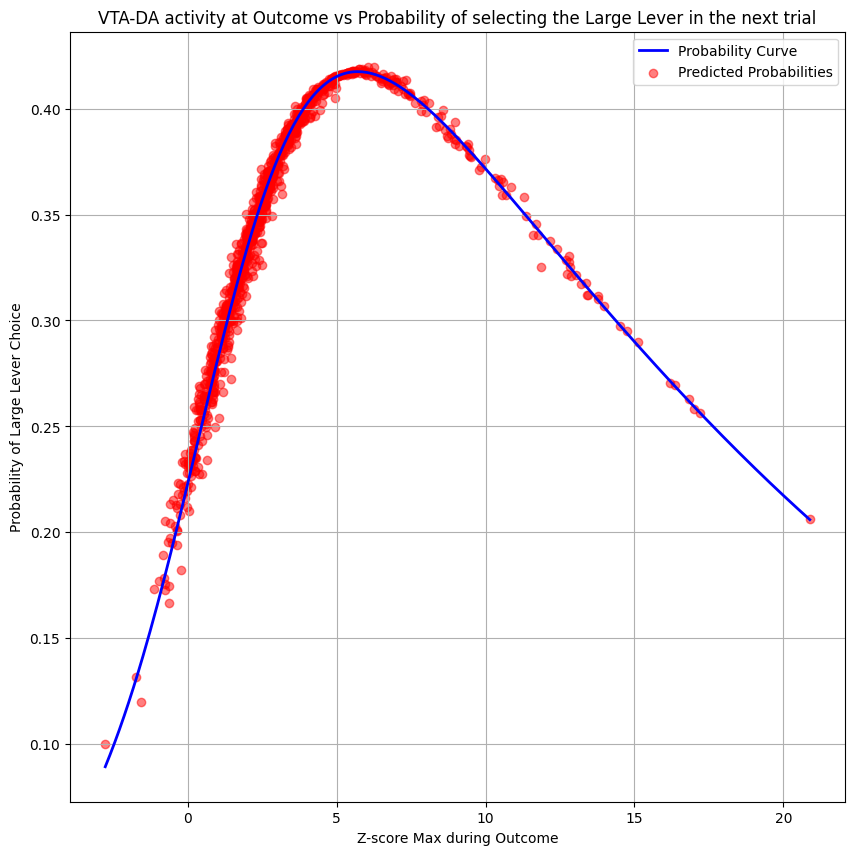

In [45]:
# Calculate the mean of other features in your dataset
X_mean = df.drop('LeverZmax', axis=1).mean()

# Generate a range of values for LeverZmax
lever_zmax_range = np.linspace(df['LeverZmax'].min(), df['LeverZmax'].max(), 300)
X_pred = np.repeat(X_mean.values.reshape(1, -1), len(lever_zmax_range), axis=0)
X_pred = np.insert(X_pred, 0, lever_zmax_range, axis=1)  # Insert LeverZmax values

# Calculate the predicted probability of NextLever=1 for the curve
prob_next_lever_1_curve = model.predict_proba(X_pred)[:, 2]

# Calculate the predicted probability of NextLever=1 for each data point
X_data_points = df.copy()
X_data_points['LeverZmax'] = X_data_points['LeverZmax'].astype(float)
prob_next_lever_1_points = model.predict_proba(X_data_points)[:, 2]

# Plotting the probability curve
plt.figure(figsize=(10, 10))
plt.plot(lever_zmax_range, prob_next_lever_1_curve, color='blue', label='Probability Curve', linewidth=2)

# Plotting the individual data points with their predicted probabilities
plt.scatter(df['LeverZmax'], prob_next_lever_1_points, color='red', label='Predicted Probabilities', alpha=0.5)

plt.title('VTA-DA activity at Outcome vs Probability of selecting the Large Lever in the next trial')
plt.xlabel('Z-score Max during Outcome')
plt.ylabel('Probability of Large Lever Choice')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\wonnp\Documents\GitHub\ML-For-Beginners\.virtualenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


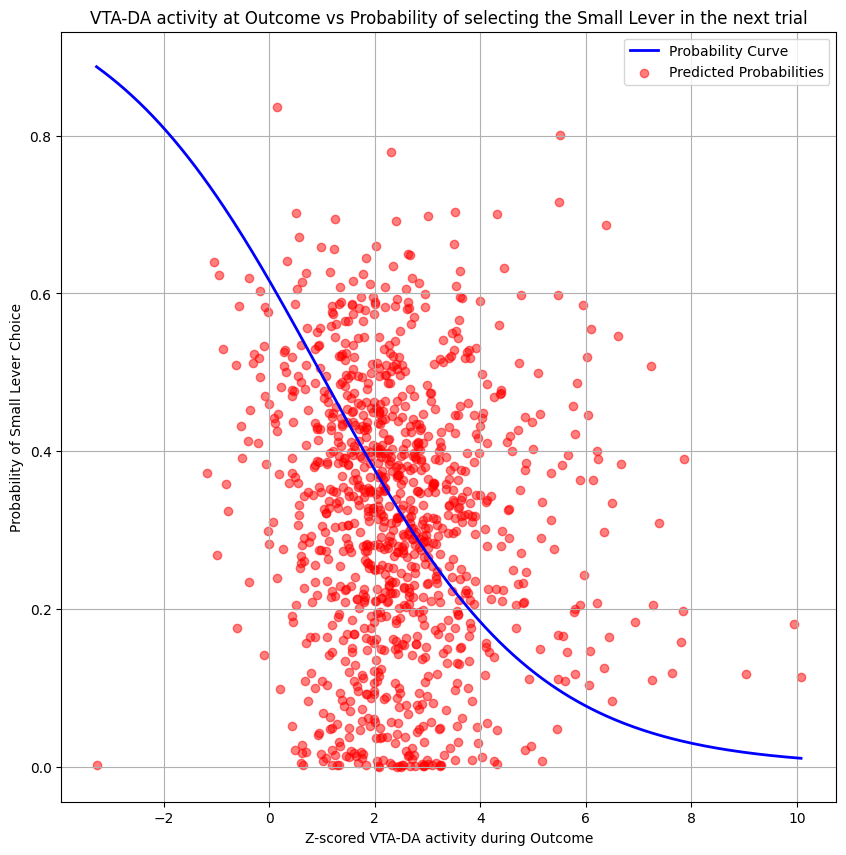

In [44]:
df = B23behav[feature_names]

# Calculate the mean of other features in your dataset
X_mean = df.drop('HLZmax', axis=1).mean()

# Generate a range of values for LeverZmax
lever_zmax_range = np.linspace(df['HLZmax'].min(), df['HLZmax'].max(), 300)
X_pred = np.repeat(X_mean.values.reshape(1, -1), len(lever_zmax_range), axis=0)
X_pred = np.insert(X_pred, 0, lever_zmax_range, axis=1)  # Insert LeverZmax values

# Calculate the predicted probability of NextLever=1 for the curve
prob_next_lever_1_curve = model.predict_proba(X_pred)[:, 1]

# Calculate the predicted probability of NextLever=1 for each data point
X_data_points = df.copy()
X_data_points['HLZmax'] = X_data_points['HLZmax'].astype(float)
prob_next_lever_1_points = model.predict_proba(X_data_points)[:, 1]

# Plotting the probability curve
plt.figure(figsize=(10, 10))
plt.plot(lever_zmax_range, prob_next_lever_1_curve, color='blue', label='Probability Curve', linewidth=2)

# Plotting the individual data points with their predicted probabilities
plt.scatter(df['HLZmax'], prob_next_lever_1_points, color='red', label='Predicted Probabilities', alpha=0.5)

plt.title('VTA-DA activity at Outcome vs Probability of selecting the Small Lever in the next trial')
plt.xlabel('Z-scored VTA-DA activity during Outcome')
plt.ylabel('Probability of Small Lever Choice')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\wonnp\Documents\GitHub\ML-For-Beginners\.virtualenv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


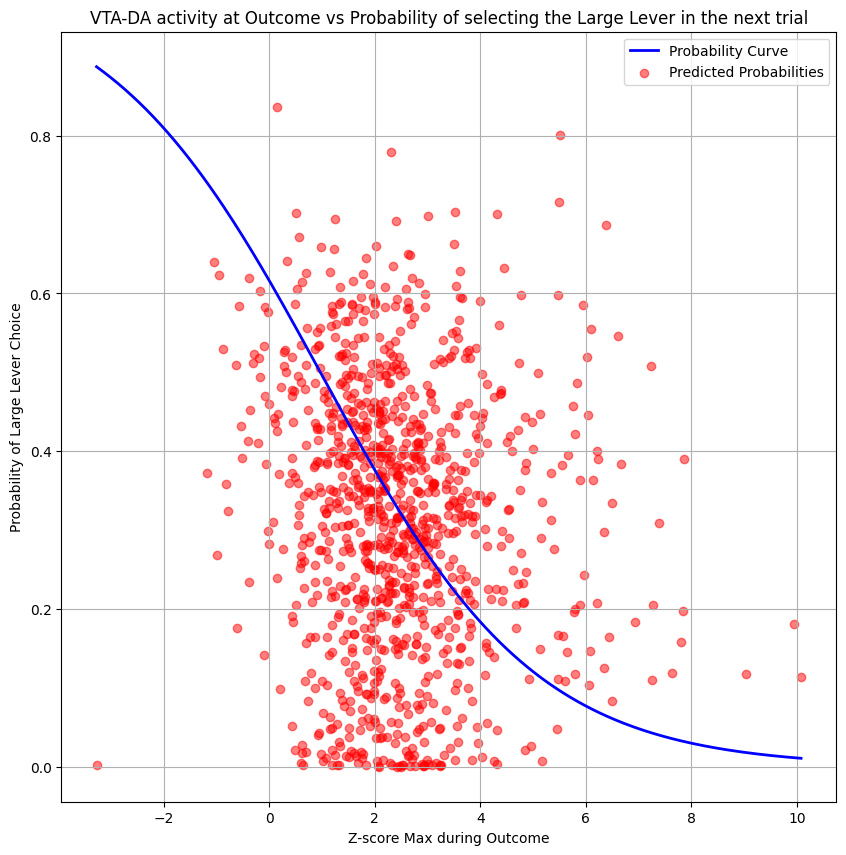

In [43]:

# Assuming your logistic regression model is named 'model'
# and it has been fitted already

# Assuming df is your DataFrame
# df = B23behav[feature_names]

# Calculate the mean of other features in your dataset
X_mean = df.drop('HLZmax', axis=1).mean()

# Generate a range of values for LeverZmax
lever_zmax_range = np.linspace(df['HLZmax'].min(), df['HLZmax'].max(), 300)
X_pred = np.repeat(X_mean.values.reshape(1, -1), len(lever_zmax_range), axis=0)
X_pred = np.insert(X_pred, 0, lever_zmax_range, axis=1)  # Insert LeverZmax values

# Calculate the predicted probability of NextLever=2 for the curve
prob_next_lever_2_curve = model.predict_proba(X_pred)[:, 1]

# Calculate the predicted probability of NextLever=2 for each data point
X_data_points = df.copy()
X_data_points['HLZmax'] = X_data_points['HLZmax'].astype(float)
prob_next_lever_2_points = model.predict_proba(X_data_points)[:, 1]

# Plotting the probability curve
plt.figure(figsize=(10, 10))
plt.plot(lever_zmax_range, prob_next_lever_2_curve, color='blue', label='Probability Curve', linewidth=2)

# Plotting the individual data points with their predicted probabilities
plt.scatter(df['HLZmax'], prob_next_lever_2_points, color='red', label='Predicted Probabilities', alpha=0.5)

plt.title('VTA-DA activity at Outcome vs Probability of selecting the Large Lever in the next trial')
plt.xlabel('Z-score Max during Outcome')
plt.ylabel('Probability of Large Lever Choice')
plt.legend()
plt.grid(True)
plt.show()


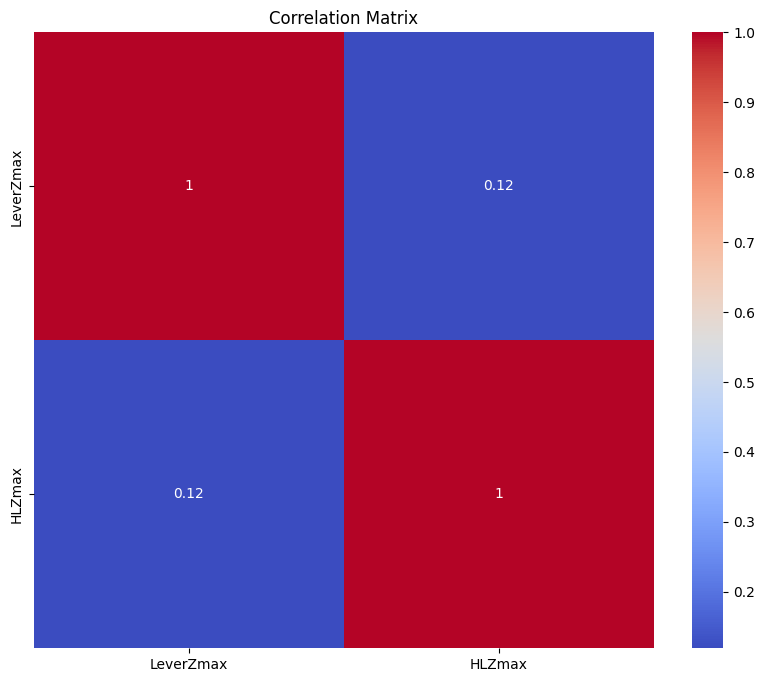

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
